In [1]:
import numpy as np
import sympy as sp
import pennylane as qml
import matplotlib.pyplot as plt

sp.init_printing()

In [ ]:
ry_params =sp.symbols('t1 t2 t3 t4 t5 t6 t7 t8 t9',real=True,)
rx_params =sp.symbols('p1 p2 p3 p4 p5 p6 p7 p8 p9',real=True)
inputs =sp.symbols('x1 x2',real=True)

ry_params =[1.0]*9
rx_params =[1.0]*9

def RX(params):
  _RX = np.array([[sp.cos(params/2),-sp.I*sp.sin(params/2)],[-sp.I*sp.sin(params/2),sp.cos(params/2)]])
  return _RX

def RY(params):
  _RY = np.array([[sp.cos(params/2),-1*sp.sin(params/2)],[sp.sin(params/2),sp.cos(params/2)]])
  return _RY


def Z_3(s='IZI'):
  m_dict = {
    'Z' : np.array([[1,0],[0,-1]]),
    'I' : np.eye(2)
  }
  result = np.kron(np.kron(m_dict[s[0]], m_dict[s[1]]), m_dict[s[2]])
  return result

def pqc_2d(layer):
  C_NOT =np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
  I_CNOT= np.kron(np.eye(2),C_NOT)
  CNOT_I= np.kron(C_NOT,np.eye(2))
  angle_embeding = np.kron(np.kron(RX(inputs[0]),RX(inputs[1])),np.eye(2))
  cnot_layer = I_CNOT@CNOT_I
  tmp=np.eye(8)
  for i in range(layer):
    ry_layer =np.kron(np.kron(RY(ry_params[i*3]),RY(ry_params[i*3+1])),RY(ry_params[i*3+2]))
    tmp= tmp@ry_layer@cnot_layer
  tmp =tmp@angle_embeding
  return tmp


def pqc_1d(layer):
  C_NOT =np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
  I_CNOT= np.kron(np.eye(2),C_NOT)
  CNOT_I= np.kron(C_NOT,np.eye(2))
  angle_embeding = np.kron(np.kron(RX(inputs[0]),RX(inputs[1])),np.eye(2))
  cnot_layer = I_CNOT@CNOT_I
  tmp=np.eye(8)
  for i in range(layer):
    ry_layer =np.kron(np.kron(RY(ry_params[i*3]),RY(ry_params[i*3+1])),RY(ry_params[i*3+2]))
    rx_layer=np.kron(np.kron(RX(rx_params[i*3]),RX(rx_params[i*3+1])),RX(rx_params[i*3+2]))
    tmp= tmp@ry_layer@rx_layer@cnot_layer
  tmp =tmp@angle_embeding
  return tmp

In [34]:
ans =pqc_1d(3)
x = np.array([1,0,0,0,0,0,0,0])
res= ans@x

r1 =np.vdot(res,Z_3("ZII")@res)
r2= np.vdot(res,Z_3("IZI")@res)
r3= np.vdot(res,Z_3("IIZ")@res)

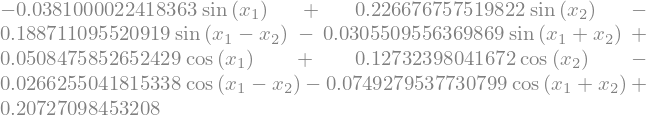

In [35]:

tmp =sp.simplify(r1)
re1 =tmp.subs({sp.I:0})
l1 =sp.simplify(re1)
l1

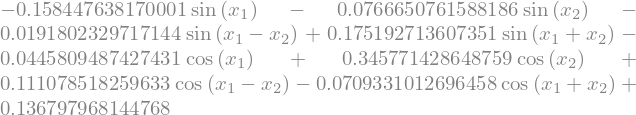

In [36]:
tmp =sp.simplify(r2)
re2 =tmp.subs({sp.I:0})
l2 =sp.simplify(re2)
l2

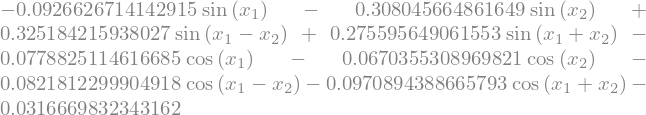

In [37]:
tmp =sp.simplify(r3)
re3 =tmp.subs({sp.I:0})
l3 =sp.simplify(re3)
l3

In [39]:
print(sp.latex(l1))
print(sp.latex(l2))
print(sp.latex(l3))

- 0.0381000022418363 \sin{\left(x_{1} \right)} + 0.226676757519822 \sin{\left(x_{2} \right)} - 0.188711095520919 \sin{\left(x_{1} - x_{2} \right)} - 0.0305509556369869 \sin{\left(x_{1} + x_{2} \right)} + 0.0508475852652429 \cos{\left(x_{1} \right)} + 0.12732398041672 \cos{\left(x_{2} \right)} - 0.0266255041815338 \cos{\left(x_{1} - x_{2} \right)} - 0.0749279537730799 \cos{\left(x_{1} + x_{2} \right)} + 0.20727098453208
- 0.158447638170001 \sin{\left(x_{1} \right)} - 0.0766650761588186 \sin{\left(x_{2} \right)} - 0.0191802329717144 \sin{\left(x_{1} - x_{2} \right)} + 0.175192713607351 \sin{\left(x_{1} + x_{2} \right)} - 0.0445809487427431 \cos{\left(x_{1} \right)} + 0.345771428648759 \cos{\left(x_{2} \right)} + 0.111078518259633 \cos{\left(x_{1} - x_{2} \right)} - 0.0709331012696458 \cos{\left(x_{1} + x_{2} \right)} + 0.136797968144768
- 0.0926626714142915 \sin{\left(x_{1} \right)} - 0.308045664861649 \sin{\left(x_{2} \right)} + 0.325184215938027 \sin{\left(x_{1} - x_{2} \right)} + 0.27

# peenylane checking

In [ ]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="torch")  # , diff_method="parameter-shift")
def quantum_circuit_n_2d(x, theta):
        # Encoding circuit: rotate qubits based on input data (x, y)
        qml.AngleEmbedding(x, wires=[0, 1], rotation="X")
        # Parameterized quantum circuit with entanglement
        for layer_count in range(3):
            for i in range(2):
                qml.CNOT(wires=[i, i + 1])
            for i in range(3):
                qml.RY(theta[layer_count * 3 + i], wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(3)]
        # return qml.state()

In [16]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="torch")  # , diff_method="parameter-shift")
def quantum_circuit_n_1d(x, theta):
        # Encoding circuit: rotate qubits based on input data (x, y)
        qml.AngleEmbedding(x, wires=[0, 1], rotation="X")
        # Parameterized quantum circuit with entanglement
        for layer_count in range(3):
            for i in range(2):
                qml.CNOT(wires=[i, i + 1])
            for i in range(3):
                qml.RX(theta[9+layer_count *3 + i], wires=i)
            for i in range(3):
                qml.RY(theta[layer_count * 3 + i], wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(3)]

In [126]:
thetas =np.array([0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0])
x=np.array([1.0,1.0])
res=quantum_circuit_n_qubit(x, thetas)

In [17]:
thetas =np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]+[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
x=np.array([1.0])
res=quantum_circuit_n_1d(x, thetas)

In [18]:
res

[tensor(0.0906, dtype=torch.float64),
 tensor(0.4781, dtype=torch.float64),
 tensor(0.1899, dtype=torch.float64)]

# function drawing

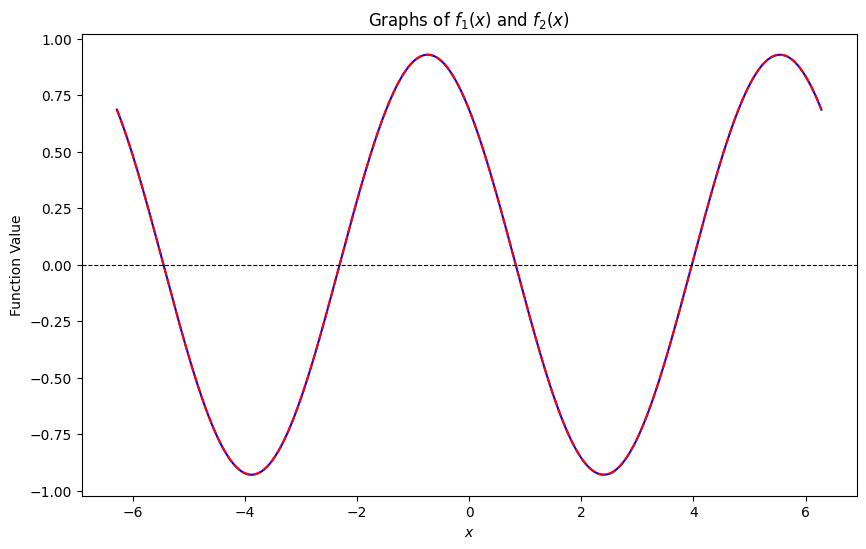

In [40]:


# Parameters
theta1 = 0.74
theta2 = -0.38

# Functions
f1 = lambda x: np.cos(theta2) * np.cos(x + theta1)
f2 = lambda x: (np.cos(theta1 - theta2 + x) + np.cos(theta1 + theta2 + x)) / 2

# x values
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
# Compute y values
y1 = f1(x)
y2 = f2(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label=r'$f_1(x) = \cos(\theta_2) \cos(x + \theta_1)$', color='blue')
plt.plot(x, y2, label=r'$f_2(x) = \frac{\cos(\theta_1 - \theta_2 + x) + \cos(\theta_1 + \theta_2 + x)}{2}$', color='red', linestyle='--')

# Customizing the plot
plt.title('Graphs of $f_1(x)$ and $f_2(x)$')
plt.xlabel('$x$')
plt.ylabel('Function Value')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y = 0
plt.axvline(0, color='black', linewidth=0)
